Here I will consider linear, regularized linear models and tree based models as well as model ensembling techniques. 
Also, I will design and implement cross-validation system that aims to best capture generalization performance of the model.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
from pathlib import Path
from src.clean import clean

data_dir = Path("../data")
train_df = pd.read_csv(data_dir / "train.csv")

dfx, label = clean(train_df)


### Modeling pipeline design

Preprocessor is being used for each model separately to avoid potential leakage of statistics from transformers like power transform and scalers. It is important to note that due to the limited size of the data set in this instance, the preprocessor is being repeatedly utilized in each pipeline, however for bigger data sets the preprocessor and other elements such as automatic feature selection, target transformer would be designed without such iterations. 

To avoid overly optimistic expectations about models predictive performance, generally the results are estimated using nested cross-validation. This is because the hyperparameter tuning process itself selects the model with the highest inner cross-validation score. When there are many hyperparameter combinations and the inner cross-validation scores have relatively large standard deviations, choosing the maximum value can lead to overestimating the true generalization performance of the final model. Using an outer cross-validation procedure provides a more reliable estimate of the generalization performance of the entire modeling process, including the impact of hyperparameter tuning.

In [3]:
from sklearn.model_selection import KFold

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Linear models

#### Linear regression

For its simplicity it is generally a good practice to use linear regression as a baseline model for regression problems.
However, linear regression tends to give high weights to certain features, which can cause the model to behave unexpectedly. To address this issue, it is common to use some form of regularized linear models.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from src.preprocessor import preprocessor

lr_pipeline = make_pipeline(
    preprocessor,
    SelectFromModel(LassoCV()),
    TransformedTargetRegressor(
        regressor=LinearRegression(), 
        func=np.log10, 
        inverse_func=sp.special.exp10
    )
)
lr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'GarageType',
                                                   'MiscFeature', 'SaleType',
                                                   'SaleCondition'])])),
                ('selectfrommodel', SelectFromModel(estimator=LassoCV())),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LinearRegression()))])


#### Ridge regression

The Ridge regression model is a variation of the ordinary least squares linear regression model, and it is implemented by adding a L2 regularization term to the objective function. The L2 regularization term is the sum of the squares of the weights of the model, which is multiplied by the regularization parameter alpha. The objective function that the Ridge regression model is trying to optimize for now has a trade-off between the fit of the model to the training data and the size of the weights in the model.

The regularization parameter alpha controls the strength of the regularization term. It captures the bias-variance tradeoff that is at play in ridge regression models. By specifying a regularization parameter, we are introducing a certain amount of bias into the model in order to reduce its variance. A small value of alpha corresponds to a weak regularization and less constraint on the size of the weights, while a large value of alpha corresponds to a stronger regularization and more constraint on the size of the weights. However, it is important to note that if the regularization parameter is set too high, it can introduce more bias than desired and negatively impact the model's performance. 

In short Ridge regression model can be used to control the complexity of the model and improve the generalization performance on unseen data by selecting an appropriate value of alpha.

In [5]:
from sklearn.linear_model import RidgeCV

alphas = np.linspace(0.01, 100, num=1000)

ridge_pipeline = make_pipeline(
    preprocessor,
    SelectFromModel(LassoCV()),
    TransformedTargetRegressor(
        regressor=RidgeCV(
            alphas=alphas, 
            cv=inner_cv, 
            #store_cv_values=True,
            scoring="neg_mean_squared_error", 
            ), 
        func=np.log1p, 
        inverse_func=np.expm1
    ) 
)
ridge_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
                                                              cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                                              scoring='neg_mean_squared_error')))])


#### Lasso regression

Lasso regression is another way of regularizing linear models. In a lasso model, the penalty is applied to the size of the weights in the model in a similar manner as in ridge regression. However, the penalty in a lasso model is an L1 regularization term. The effect of this penalty is to drive the weights of the model towards zero, but it also has the additional property of setting some weights exactly to zero, effectively performing feature selection.

The strength of the penalty in a lasso model is controlled by a hyperparameter called alpha. A larger value of alpha corresponds to a stronger penalty and more feature selection, while a smaller value of alpha corresponds to a weaker penalty and less feature selection.

Like in ridge regression, we can use lasso regression to control the complexity of the model and avoid overfitting to the training data, which can lead to poor generalization performance on unseen data. However, the feature selection capability of the lasso can be useful in cases where we have a large number of features and want to select the most important ones for the model.

In [6]:
lasso_pipeline = make_pipeline(
    preprocessor,
    SelectFromModel(LassoCV()),
    TransformedTargetRegressor(
        regressor=LassoCV(
                n_alphas=1000,
                cv=inner_cv
                ), 
            func=np.log1p, 
            inverse_func=np.expm1
    )
)
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
                                                   'Exterior2nd', 'MasVnrType',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'GarageType',
                                                   'MiscFeature', 'SaleType',
                                                   'SaleCondition'])])),
                ('selectfrommodel', SelectFromModel(estimator=LassoCV())),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LassoCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                                              n_alphas=1000)))])

#### Elastic net
Elastic net regression is a combination of ridge and Lasso regression, where the penalty term is a combination of the L2 and L1 regularization terms. This allows elastic net regression to balance the tradeoff between the simplicity of the model (as in ridge regression) and the sparsity of the model (as in Lasso regression).

In elastic net regression, the penalty is applied to the size of the weights in the model and is controlled by two hyperparameters: alpha and l1_ratio. Alpha determines the overall strength of the penalty, while l1_ratio determines the relative weighting of the L1 and L2 penalty terms. 

A larger value of alpha corresponds to a stronger penalty and smaller weight values, while a smaller value of alpha corresponds to a weaker penalty and larger weight values. Similarly, a value of l1_ratio closer to 1 will give more weight to the L1 penalty and produce a sparser model, while a value closer to 0 will give more weight to the L2 penalty and produce a model with higher complexity.

By using elastic net regression, we can control the complexity and sparsity of the model. However, it is important to carefully tune the hyperparameters alpha and l1_ratio to achieve a good balance between bias and variance in the model.

In [7]:
from sklearn.linear_model import ElasticNetCV

l1_ratio = [0.1, 0.4, 0.5, 0.55, 0.6, 0.7, 0.9, 0.95, 0.99, 1]

elasticnet_pipeline = make_pipeline(
    preprocessor,
    SelectFromModel(LassoCV()),
    TransformedTargetRegressor(
        regressor=ElasticNetCV(
                cv=inner_cv,
                l1_ratio=l1_ratio,
                max_iter=5000
            ), 
            func=np.log1p, 
            inverse_func=np.expm1
    )
)
elasticnet_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
                                                   'MiscFeature', 'SaleType',
                                                   'SaleCondition'])])),
                ('selectfrommodel', SelectFromModel(estimator=LassoCV())),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=ElasticNetCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                                                   l1_ratio=[0.1,
                                                                             0.4,
                                                                             0.5,
                                                                             0.55,
                                                                             0.6,
                                                                             0.7,
                                                                             0.9,
                                                                             0.95,
                                                                             0.99,
                                                                             1],
                                                                   max_iter=5000)))])


### Kernel models

#### Support Vector Machines

Support Vector Machines (SVMs) belong to the class of models known as kernel methods or kernel-based learning algorithms. These models are called kernel methods because they use a kernel function to transform the input data into a higher-dimensional space, where it becomes linearly separable. The kernel trick is used to find an optimal boundary or hyperplane that separates the data into different classes. This boundary is known as the maximum-margin hyperplane. The idea behind this approach is to find the hyperplane with the largest margin, which separates the data into different classes while maximizing the distance between the data points and the hyperplane

The kernel function is used to compute the inner product of two vectors in a higher-dimensional space, without having to explicitly compute the coordinates of the data in that space. This allows us to perform complex non-linear classification or regression tasks using linear methods.

In [8]:
from sklearn.svm import SVR

svr_pipeline = make_pipeline(
    preprocessor,
    SelectFromModel(LassoCV()),
    TransformedTargetRegressor(
        regressor= SVR(
            kernel='poly',
            degree=2
        ),
        func=np.log1p, 
        inverse_func=np.expm1
    )
)
svr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'GarageType',
                                                   'MiscFeature', 'SaleType',
                                                   'SaleCondition'])])),
                ('selectfrommodel', SelectFromModel(estimator=LassoCV())),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=SVR(degree=2,
                                                          kernel='poly')))])

### Tree Based Models

Tree based models are advanced and powerful methods for working with tabular datasets. They work by building a tree-like model of decisions based on the features of the data.

In a simple decision tree model, the data is split into smaller and smaller subsets based on the values of the features. This process continues until the data is fully partitioned into leaves, each of which represents a prediction. 

It is important to note that individual decision trees can be limited in their ability to capture complex relationships in the data. This is because they make constant, piecewise predictions, which may not be flexible enough to capture more subtle patterns in the data. As a result, individual decision trees may not be the best choice for a standalone model. However, they can be useful as building blocks for more powerful models, known as ensembles. 

Ensemble models combine the predictions of multiple individual models to make more accurate and robust predictions. There are several types of ensemble tree-based models, including bagging (random forests), boosting(gradient boosted decision trees).

In a decision tree model, the complexity of the model is controlled by the depth of the tree. The depth of the tree refers to the number of layers or levels in the tree. A tree with a larger depth will have more layers and will be more complex, while a tree with a smaller depth will have fewer layers and will be simpler.

Therefore, by tuning the depth fot the tree you can control the complexity of the model and avoid overfitting to the training data. A tree with a larger depth will be more complex and may be more prone to overfitting, while a tree with a smaller depth will be simpler and may have better generalization performance. 


#### Random forrest 

Bagging ensembles, such as random forests, train multiple individual models on different subsets of the data and combine their predictions through averaging or voting.
In a random forest, the individual trees are expected to be deep in order to overfit the training data. This is because the goal of each tree in a random forest is to fit the data as well as possible, and overfitting is actually desirable at this stage.

Overfitting of the individual trees is mitigated when the trees are combined to make a final prediction, as the ensemble model is able to average out the overfitting of the individual trees and produce a more generalizable prediction. However, if the individual trees are underfitted (i.e. shallow), then the ensemble model may also be underfitted and have poor generalization performance.

Therefore, it is important to allow the trees in a random forest to grow deep enough to capture the patterns in the data, but not so deep that they overfit the training data. This can be achieved by using techniques such as early stopping or setting a maximum depth for the trees.

In [9]:
import joblib
from sklearn.ensemble import RandomForestRegressor

rf_study = joblib.load("src/hyperparameter_tuning/study_rf.pkl")

rf_pipeline = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor= RandomForestRegressor(**rf_study),
        func=np.log1p, 
        inverse_func=np.expm1
    )
)
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
                                                   'CentralAir', 'GarageType',
                                                   'MiscFeature', 'SaleType',
                                                   'SaleCondition'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(max_depth=45,
                                                                            max_features=0.0650166290895576,
                                                                            min_samples_leaf=4.983311015835904e-05,
                                                                            min_samples_split=4.696196729393275e-05,
                                                                            n_estimators=1000)))])


#### Gradient boosting

Gradient Boosting is a powerful ensemble method that combines multiple weak or average models to produce a powerful ensemble model. The main idea behind this technique is to train multiple individual models sequentially, with each model focusing on correcting the mistakes of the previous model. This is achieved by fitting the new model to the residual errors of the previous model, rather than the original response variable. By training models in this way, the algorithm is able to improve the overall performance of the ensemble model by reducing the bias and variance of the individual models.

The algorithm starts with a single decision tree as the initial model and then iteratively adds new models to the ensemble. In each iteration, the new model is trained on the residual errors of the previous ensemble model. The final ensemble model is the sum of all the weak models, where the contribution of each model is determined by a weighting factor. The weighting factor is determined by minimizing the loss function using gradient descent.

In [10]:
import xgboost as xgb

xgb_study = joblib.load("src/hyperparameter_tuning/study_xgb.pkl")
xgb_pipeline = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=xgb.XGBRegressor(**xgb_study.best_params),
        func=np.log1p, 
        inverse_func=np.expm1
    )
)
xgb_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['BsmtFinSF1', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'GarageArea']),
                                                 ('pi...
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.08721353849241338,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=3,
                                                                   max_leaves=17,
                                                                   min_child_weight=14.094902119838498,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None, ...)))])

### Model stacking

Model stacking is an ensemble technique that involves training multiple models and then using their predictions as input to a higher-level model, also known as a meta-model. The goal of model stacking is to improve the performance of the ensemble by combining the predictions of multiple models.

The base models can be of different types and can be trained using different algorithms, such as decision trees, neural networks, etc. The meta-model is then trained on the predictions of the base models, rather than the original input features.

The main advantage of model stacking is that it allows the base models to focus on different aspects of the data and then combine their predictions in a way that is more informative than any single model. By training the meta-model on the predictions of the base models, the meta-model can learn to weight the predictions of the base models in a way that improves the overall performance of the ensemble. Therefore it is common to use regularized linear models as meta learners as it would perform automatic weighting of base learner predictions.

In [11]:
from sklearn.ensemble import StackingRegressor

estimators = [
        ('lr', lr_pipeline), 
        ('ridge', ridge_pipeline),
        ('lasso', lasso_pipeline),
        ('enet', elasticnet_pipeline), 
        ('svr', svr_pipeline),
        ('xgb',xgb_pipeline),
        ('rf', rf_pipeline)
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator= RidgeCV(
    ),
    cv=inner_cv
)
stacking_regressor

StackingRegressor(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                  estimators=[('lr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                fill_value=0,
                                                                                                                strategy='constant')),
                                                                                                 ('robustscaler',
                                                                                                  RobustScaler()),
                                                                                                 ('polynomialfeatures',
                                                                                                  PolynomialFeatures(include...
                                                                                  'MiscFeature',
                                                                                  'SaleType',
                                                                                  'SaleCondition'])])),
                                               ('transformedtargetregressor',
                                                TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                           inverse_func=<ufunc 'expm1'>,
                                                                           regressor=RandomForestRegressor(max_depth=45,
                                                                                                           max_features=0.0650166290895576,
                                                                                                           min_samples_leaf=4.983311015835904e-05,
                                                                                                           min_samples_split=4.696196729393275e-05,
                                                                                                           n_estimators=1000)))]))],
                  final_estimator=RidgeCV())

### Model comparison

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,  cross_validate
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

trials = []

N_TRIALS = 3
for i in range(N_TRIALS):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    models = [
            ('Linear Regression', lr_pipeline), 
            ('Ridge Regression', ridge_pipeline),
            ('Lasso Regression', lasso_pipeline),
            ('Elastic Net', elasticnet_pipeline), 
            ('Support Vector Machine', svr_pipeline),
            ('Gradient Boosting',xgb_pipeline),
            ('Random Forest', rf_pipeline),
            ('Stacked Enet', stacking_regressor)
            ]

    dfs = []     
    results = []
    names = []
   
    for name, model in models:
        if model == svr_pipeline:
            param_dist = {
                        'transformedtargetregressor__regressor__kernel': ['rbf', 'poly'],
                        'transformedtargetregressor__regressor__degree': [2,3]
            } 
            randomized_search_results= RandomizedSearchCV(
                model, 
                param_distributions=param_dist,
                cv=inner_cv,
                return_train_score=True,
                #n_trials = 1,
                #scoring= mean_squared_error,
                n_jobs=-1
            )
            cv_results = cross_validate(
                randomized_search_results, 
                dfx, 
                label, 
                cv=outer_cv,
                scoring=["neg_mean_squared_error", 'neg_mean_absolute_error','r2'], 
                return_train_score=True, 
                return_estimator=True,
                n_jobs=-1
            )        
        else:
            cv_results = cross_validate(
                    model, 
                    dfx, 
                    label, 
                    cv=outer_cv,
                    scoring=["neg_mean_squared_error", 'neg_mean_absolute_error','r2'], 
                    return_train_score=True, 
                    return_estimator=True,
                    n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        temp_df = pd.DataFrame(cv_results)
        temp_df['model'] = name
        dfs.append(temp_df)
    trials.extend(dfs)
results = pd.concat(trials, ignore_index=True)
scoring = ['test_neg_mean_squared_error','train_neg_mean_squared_error',"test_neg_mean_absolute_error","train_neg_mean_absolute_error"]
results.loc[:, scoring] = results.loc[:, scoring].applymap(lambda x: x*-1)

In [13]:
print(f'After {N_TRIALS} trials and nested cross validation each with 5 folds for {len(models)} models we have {results.shape[0]} samples of test results to analyze.')

After 3 trials and nested cross validation each with 5 folds for 8 models we have 120 samples of test results to analyze.


In [14]:
results.head(5)

,fit_time,score_time,estimator,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2,model
0,0.320283,0.013100,(ColumnTransformer(transformers=[('pipeline-1'...,3.016031e+08,2.836679e+08,12375.320726,11755.911643,0.937653,0.939302,Linear Regression
1,0.343155,0.013785,(ColumnTransformer(transformers=[('pipeline-1'...,4.015185e+08,2.794129e+08,13533.041856,11640.345247,0.908343,0.941632,Linear Regression
2,0.225207,0.012441,(ColumnTransformer(transformers=[('pipeline-1'...,3.420999e+08,2.733889e+08,13206.440860,11530.307821,0.930874,0.941198,Linear Regression
3,0.337476,0.011978,(ColumnTransformer(transformers=[('pipeline-1'...,3.637902e+08,2.730903e+08,13394.386410,11527.274943,0.928327,0.940840,Linear Regression
4,0.329621,0.011992,(ColumnTransformer(transformers=[('pipeline-1'...,3.904002e+08,2.765888e+08,12704.431750,11811.623071,0.908333,0.942599,Linear Regression


In [15]:
score_cols = ["test_neg_mean_squared_error", "test_neg_mean_absolute_error", "test_r2"]
score_stats = results.groupby("model")[score_cols].agg(["mean"])
score_stats.columns = ["_".join(col) for col in score_stats.columns]
score_stats.reset_index(inplace=True)
score_stats

,model,test_neg_mean_squared_error_mean,test_neg_mean_absolute_error_mean,test_r2_mean
0,Elastic Net,3.657712e+08,12996.681127,0.921497
1,Gradient Boosting,4.613784e+08,14326.707079,0.900930
2,Lasso Regression,3.657712e+08,12996.681127,0.921497
3,Linear Regression,3.690335e+08,13083.820339,0.920815
4,Random Forest,5.989195e+08,15963.726313,0.872160
5,Ridge Regression,3.611671e+08,12927.785802,0.922535
6,Stacked Enet,3.601640e+08,12754.152041,0.924210
7,Support Vector Machine,4.338440e+08,13911.627644,0.906982


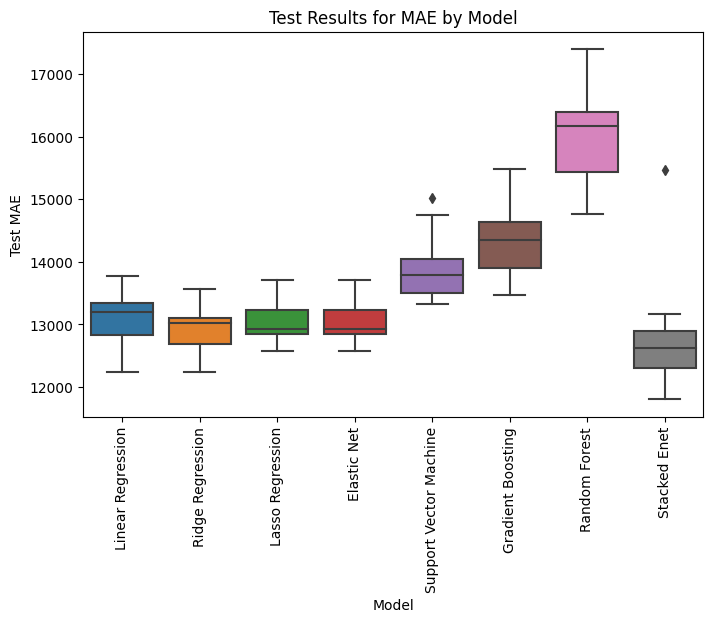

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model', y='test_neg_mean_absolute_error', data=results)
plt.title("Test Results for MAE by Model")
plt.xlabel("Model")
plt.ylabel("Test MAE")
plt.xticks(rotation=90)
plt.show()

Evaluated models include Ordinary Least Squares (OLS) regression, Ridge regression, Lasso regression, Elastic Net, Kernel regression, random forest, and gradient boosting trees.

The evaluation of the models was based on the distribution of mean absolute errors (MAE). The results suggest that the linear models (OLS, Ridge, Lasso, and Elastic Net) behave in a similar fashion, with slightly better performance from Ridge, Lasso, and Elastic Net. This suggests that L2 and L1 regularization might be relevant for this dataset.

The kernel regression model, on the other hand, had a notably lower mean compared to other models. This can be attributed to the fact that Kernel regression models are non-parametric and make no assumptions about the functional form of the relationship between the predictor and response variables, allowing for more flexibility but also potentially leading to lesser generalization performance.

Tree-based models also produced highly disperse results and performed considerably lower than expected. This might imply misconfigured hyperparameters, or inappropriate preprocessing for these types of models.

As expected, the blend of these models performed the best, the interquartile range was relatively stable and the whiskers extending to the minimum and maximum values were relatively short. This is due to the fact that blending allows leveraging the strengths of each individual model and can lead to improved accuracy and reduced overfitting.

## Goodness of fit

One way to asses the performance of models in predictive analysis is by comparing the distribution of errors on the training and testing data. This can help identify if the model is overfitting, underfitting, or has an appropriate fit. The goal is to understand if the generalization error of the model is dominated by bias, variance or noise component. Bias refers to the average error of the model across different training sets (high bias error suggest underfitting). Variance, on the other hand, measures the sensitivity of the model to changes in the training set (high variance error suggest overfitting). Usually for each dataset different learning algorithms and hyperparameters will balance tradeoff between bias and variance. 

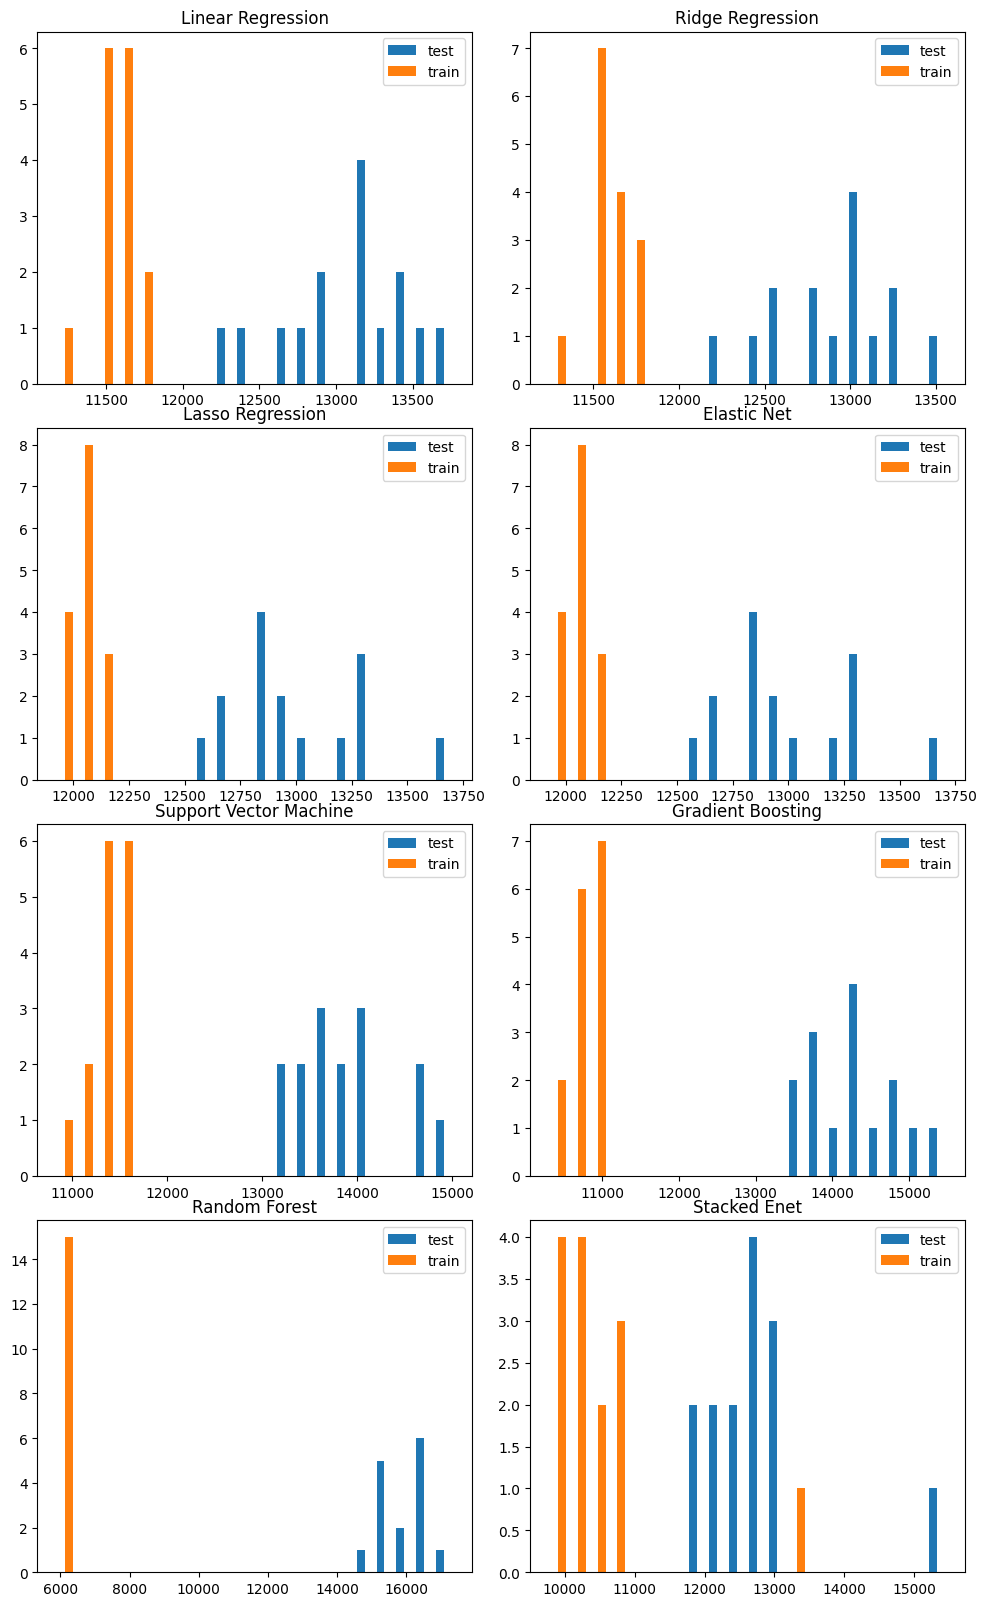

In [17]:
from src.plots.scores_plot import scores_plot

scores_plot(names, results)

When a model is overfitting, it is typically fitting the training data too closely, and as a result, it is not generalizing well to unseen data. This can be seen in a graph comparing the performance of the model on the training and testing data. On a graph, overfitting would typically be represented by a low error rate on the training data and a much higher error rate on the testing data. An extreme example of this is can be noticed with random forest.
However, underfitting is suggested by high error scores for both the training and testing set which is not the case with these models. Overall, generalization performance seems fair.

In [ ]:
# Predictions
test = pd.read_csv(data_dir / "test.csv", index_col="Id")
stacking_regressor.fit(dfx,label)
yhat = stacking_regressor.predict(test)

output = pd.DataFrame({'Id': test.index, 'SalePrice': yhat})
output.to_csv(data_dir / 'submission.csv', index=False)

Further improvements:
* Different feature selection strategies
* Introducing polynomial features in the dataset
* Examine relationships between target and features to determine what transformations can be applied (log, reciprocal)
* Increase diversity between base learners
* Hyperparameter tuning for random forest
* Fine-tuning xgb hyperparameters 
* Outliers for categorical data
* Separate pipelines for tree, kernel, and linear models
* More complicated model with more base learners and tree-based model as a meta estimator and blended predictions to reduce variance